# Additional Strategies for Confronting the Partition Function

In the [previous post](https://cavaunpeu.github.io/2018/10/20/thorough-introduction-to-boltzmann-machines/) we introduced Boltzmann machines and the infeasibility of computing the gradient of its log-partition function $\nabla_{\theta}\log{Z}$. To this end, we explored one strategy for its approximation: Gibbs sampling. Gibbs sampling is a viable alternative because the expression for this gradient simplifies to an expectation over the model distribution, which can be approximated with Monte Carlo samples.

In this post, we'll highlight the imperfections of even this approach, then present more preferable alternatives.

## Pitfalls of Gibbs sampling

To refresh, the two gradients we seek to compute in a reasonable amount of time are:

$$
\nabla_{w_{i, j}}\log{Z} = \mathop{\mathbb{E}}_{x \sim p_{\text{model}}} [x_i  x_j]\\
\nabla_{b_{i}}\log{Z} = \mathop{\mathbb{E}}_{x \sim p_{\text{model}}} [x_i]
$$

Via Gibbs sampling, we approximate each by:

1. Burning in a Markov chain w.r.t. our model, then selecting $n$ samples from this chain
2. Evaluating both functions ($x_i  x_j$, and $x_i$) at these samples
3. Taking the average of each

Concretely:

$$
\nabla_{w_{i, j}}\log{Z} \approx \frac{1}{N}\sum\limits_{k=1}^N x^{(k)}_i  x^{(k)}_j\quad\text{where}\quad x^{(k)} \sim p_{\text{model}}\\
\nabla_{b_{i}}\log{Z} \approx \frac{1}{N}\sum\limits_{k=1}^N x^{(k)}_i\quad\text{where}\quad x^{(k)} \sim p_{\text{model}}
$$

**We perform this sampling process at each gradient step.**

### The cost of burning in each chain

Initializing a Markov chain at a random sample incurs a "burn-in" process which comes at non-trivial cost. If paying this cost at each gradient step, it begins to add up. How can we do better?

**In the remainder of the post, we'll explore two new directives for approximating the negative phase more cheaply, and the algorithms they birth.**

## Directive \#1: Cheapen the burn-in process

## Stochastic maximum likelihood

SML assumes the premise: let's initialize our chain at a point already close to the model's true distribution—reducing or perhaps eliminating the cost of burn-in altogether.  **This given, at what sample do we initialize the chain?**

In SML, we simply initialize at the terminal value of the previous chain (i.e. the one we manufactured to compute the gradients of the previous mini-batch). **As long as the model has not changed significantly since, i.e. as long as the previous parameter update (gradient step) was not too large, this sample should exist in a region of high probability under the current model.**

In code, this might look like:

```python
n_obs, dim = X.shape  # X holds all of our observations

# Vanilla Gibbs sampling
samples = [np.zeros(dim)]

# SML
samples = [previous_samples[-1]]
```

### Implications
Per the expression for the full log-likelihood gradient, e.g. $\nabla_{w_{i, j}}\log{\mathcal{L}} = \mathop{\mathbb{E}}_{x \sim p_{\text{data}}} [x_i  x_j] - \mathop{\mathbb{E}}_{x \sim p_{\text{model}}} [x_i  x_j]$, the negative phase works to "reduce the probability of the points in which the model strongly, yet wrongly, believes".[^1] Since we approximate this term at each parameter update with samples *roughly from* the current model's true distribution, **we do not encroach on this foundational task.**

## Contrastive divergence

Alternatively, in the contrastive divergence algorithm, we initialize the chain at each gradient step with a sample from the data distribution.

### Implications

With no guarantee that the data distribution resembles the model distribution, we may systematically fail to sample, and thereafter "suppress," points that are incorrectly likely under the latter (as they do not appear in the former!). **This incurs the growth of "spurious modes"** in our model, aptly named.[^1]

In code, this might look like:

```python
# Vanilla Gibbs sampling
samples = [np.zeros(dim)]

# SML
samples = [previous_samples[-1]]

# Contrastive divergence
samples = [X[np.random.choice(n_obs)]]
```

Cheapening the burn-in phase indeed gives us a more efficient training routine. Moving forward, what are some even more aggressive strategies we can explore?

## Directive \#2: Skip the computation of $Z$ altogether

Canonically, we write the log-likelihood of our Boltzmann machine as follows:

$$
\begin{align*}
\log{\mathcal{L}(x)}
&= \log{\frac{\exp{(H(x))}}{Z}}\\
&= \log{\big(\exp{(H(x))}\big)} - \log{Z}\\
&= H(x) - \log{Z}
\end{align*}
$$

Instead, what if we simply wrote this as:

$$
\log{\mathcal{L}(x)} = H(x) - c
$$

or, more generally:

$$
\log{p_{\text{model}}(x)} = \log{\tilde{p}_{\text{model}}(x; \theta)} - c
$$

and estimated $c$ as a parameter?

**Immediately, we remark that if we optimize this model with maximum likelihood, our algorithm will, trivially, make $c$ arbitrarily negative.** In other words, the quickest way to increase the thing on the left is to decrease $c$.

How might we better phrase this problem?

## Noise contrastive estimation

Ingeniously, NCE proposes an alternative:

1. Posit two distributions: the model, and a noise distribution
2. Given a data point, predict from which distribution this point was generated

Let's unpack this a bit.

Under an (erroneous) MLE formulation, we would optimize the following objective:

$$
\theta, c = \underset{\theta, c}{\arg\max}\  \mathbb{E}_{x \sim p_{\text{data}}} [\log{p_{\text{model}}}(x)]
$$

Under NCE, we're going to replace two pieces so as to perform the binary classification task described above (with 1 = "model", and 0 = "noise").

First, let's swap $\log{p_{\text{model}}}(x)$ with $\log{p_{\text{joint}}}(y = 0\vert x)$, where:

$$
p_{\text{joint}}(x\vert y) =
\begin{cases}
p_{\text{noise}}(x)\quad y = 0\\
p_{\text{model}}(x)\quad y = 1\\
\end{cases}
$$

$$
p_{\text{joint}}(x, y)
= p_{\text{joint}}(y = 0)p_{\text{noise}}(x) + p_{\text{joint}}(y = 1)p_{\text{model}}(x)
$$

$$
p_{\text{joint}}(y = 0\vert x)
= \frac{p_{\text{joint}}(y = 0)p_{\text{noise}}(x)}{p_{\text{joint}}(y = 0)p_{\text{noise}}(x) + p_{\text{joint}}(y = 1)p_{\text{model}}(x)}
$$

Finally:

$$
\theta, c = \underset{\theta, c}{\arg\max}\  \mathbb{E}_{x \sim p_{\text{data}}} [\log{p_{\text{joint}}(y = 0\vert x)}]
$$

From here, we need to update $x \sim p_{\text{data}}$ to include $y$. We'll do this in two pedantic steps.

First, let's write:

$$
\theta, c = \underset{\theta, c}{\arg\max}\  \mathbb{E}_{x, y=0\ \sim\ p_{\text{noise}}} [\log{p_{\text{joint}}(y\vert x)}]
$$

This equation:

1. Builds a classifier that discriminates between samples generated from the model distribution and noise distribution **trained only on samples from the latter.** (Clearly, this will not make for an effective classifier.)
2. To train this classifier, we note that the equation asks us to maximize the likelihood of the noise samples under the noise distribution—where the noise distribution itself has no actual parameters we intend to train!

In solution, we trivially expand our expectation to one over both noise samples, and data samples. In doing so, in predicting $\log{p_{\text{joint}}(y = 1\vert x)} = 1 - \log{p_{\text{joint}}(y = 0\vert x)}$, **we'll be maximizing the likelihood of the data under the model.**

$$
\theta, c = \underset{\theta, c}{\arg\max}\  \mathbb{E}_{x, y\ \sim\ p_{\text{train}}} [\log{p_{\text{joint}}(y \vert x)}]
$$

where:

$$
p_{\text{train}}(x\vert y) =
\begin{cases}
p_{\text{noise}}(x)\quad y = 0\\
p_{\text{data}}(x)\quad y = 1\\
\end{cases}
$$

As a final step, we'll expand our object into something more elegant:

$$
\begin{align*}
p_{\text{joint}}(y = 0\vert x)
&= \frac{p_{\text{joint}}(y = 0)p_{\text{noise}}(x)}{p_{\text{joint}}(y = 0)p_{\text{noise}}(x) + p_{\text{joint}}(y = 1)p_{\text{model}}(x)}\\
&= \frac{1}{1 + \frac{p_{\text{joint}}(y = 1)p_{\text{model}}(x)}{p_{\text{joint}}(y = 0)p_{\text{noise}}(x)}}\\
\end{align*}
$$

Assuming *a priori* that $p_{\text{joint}}(x, y)$ is $k$ times more likely to generate a noise sample, i.e. $\frac{p_{\text{joint}}(y = 1)}{p_{\text{joint}}(y = 0)} = \frac{1}{k}$:

$$
\begin{align*}
p_{\text{joint}}(y = 0\vert x)
&= \frac{1}{1 + \frac{p_{\text{model}}(x)}{p_{\text{noise}}(x)\cdot k}}\\
&= \frac{1}{1 + \exp\big(\log{\frac{p_{\text{model}}(x)}{{p_{\text{noise}}(x)\cdot k}}}\big)}\\
&= \sigma\bigg(-\log{\frac{p_{\text{model}}(x)}{{p_{\text{noise}}(x)\cdot k}}}\bigg)\\
&= \sigma\bigg(\log{k} + \log{p_{\text{noise}}(x)} - \log{p_{\text{model}}(x)}\bigg)\\
p_{\text{joint}}(y = 1\vert x)
&= 1 - \sigma\bigg(\log{k} + \log{p_{\text{noise}}(x)} - \log{p_{\text{model}}(x)}\bigg)
\end{align*}
$$

Given a joint training distribution over $(X_{\text{data}}, y=1)$ and $(X_{\text{noise}}, y=0)$, this is the target we'd like to maximize.

### Implications

For our training data, **we require the ability to sample from our noise distribution.**

For our target, **we require the ability to compute the likelihood of some data under our noise distribution.**

Therefore, these criterion do place practical restrictions on the types of noise distributions that we're able to consider.

### Extensions

We briefly alluded to the fact that our noise distribution is non-parametric. However, there is nothing stopping us from evolving this distribution and giving it trainable parameters, then updating these parameters such that it generates increasingly "optimal" samples.

Of course, we would have to design what "optimal" means. One interesting approach is called [Adversarial Contrastive Estimation
](https://arxiv.org/abs/1805.03642), wherein the authors adapt the noise distribution to generate increasingly "harder negative examples, which forces the main model to learn a better representation of the data."[^2]

## Negative sampling

Negative sampling is the same as NCE except:

1. We consider noise distributions whose likelihood we cannot evaluate
2. To accommodate, we simply set $p_{\text{noise}}(x) = 1$

Therefore:

$$
\begin{align*}
p_{\text{joint}}(y = 0\vert x)
&= \frac{1}{1 + \frac{p_{\text{model}}(x)}{p_{\text{noise}}(x)\cdot k}}\\
&= \frac{1}{1 + \frac{p_{\text{model}}(x)}{ k}}\\
&=\sigma(-\frac{p_{\text{model}}(x)}{ k})\\
&=\sigma(\log{k} - \log{p_{\text{model}}(x)})\\
p_{\text{joint}}(y = 1\vert x)
&= 1 - \sigma(\log{k} - \log{p_{\text{model}}(x)})
\end{align*}
$$

## In code

Since I learn best by implementing things, let's play around. Below, we train Boltzmann machines via noise contrastive estimation and negative sampling.


In [369]:
from itertools import repeat

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
import torch.nn as nn
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms

# Load data

For this exercise, we'll fit a Boltzmann machine to the [Fashion MNIST](https://www.kaggle.com/zalando-research/fashionmnist) dataset.

The following code takes influence from a variety of posts like [this](https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/) which provide code for loading and displaying popular image datasets via [torchvision](https://pypi.org/project/torchvision/).

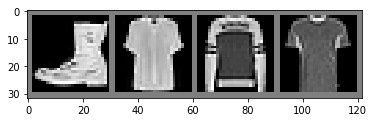

In [370]:
BATCH_SIZE = 4

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# load data
trainset = dset.mnist.FashionMNIST(root = 'data/fashion-mnist', download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# get data dimensionality size
n_units = trainset[0][0].view(-1).size()[0]

# Define model

Below, as opposed to in the previous post, I offer a vectorized implementation of the Boltzmann energy function.

This said, the code is still imperfect: especially re: the line in which I iterate through data points individually to compute the joint likelihood.

Finally, in `Model._H`, I divide by 1000 to get this thing to train. The following is only a toy exercise (like many of my posts); I did not spend much time tuning parameters.

In [371]:
def sigmoid(z):
    return 1 / (1 + torch.exp(-z))


class Model(nn.Module):
    
    def __init__(self, n_units, seed=42):
        super().__init__()
        torch.manual_seed(seed)
        
        self.params = nn.Linear(n_units, n_units, bias=True)
        torch.nn.init.xavier_uniform_(self.params.weight)
        self.c = nn.Parameter(torch.FloatTensor([1.]))
        self.diagonal_mask = (~torch.eye(n_units).byte()).float()
        self.n_units = n_units
        
    def forward(self, x, log=False):
        return self._likelihood(x, log=log)
        
    def _unnormalized_likelihood(self, x):
        return torch.exp(self._H(x))
        
    def _H(self, x):
        H = (self.diagonal_mask * torch.triu(self.params.weight * torch.ger(x, x))).sum() + self.params.bias.sum()
        return H / 1000
    
    def _likelihood(self, x, log=False):
        """
        :param x: a vector of shape (n_units,) or (n, n_units),
            where the latter is a matrix of multiple data points
            for which to compute the joint likelihood
            
        :return: the likelihood, or log-likelihood if `log=True`
        """
        if not self.n_units in x.size() and len(x.size()) in (1, 2):
            raise('Please pass 1 or more points of `n_units` dimensions')
           
        # compute unnormalized likelihoods
        multiple_samples = len(x.shape) == 2
        if multiple_samples:
            likelihood = [self._unnormalized_likelihood(point) for point in x]
        else:
            likelihood = [self._unnormalized_likelihood(x)]
        
        if log:
            return torch.stack([torch.log(lik) - torch.log(self.c) for lik in likelihood])
        else:
            return torch.stack([lik / self.c for lik in likelihood])
        
    def sample(self, n_samples=100, init_sample=None, burn_in=25, every_n=10) -> np.array:

        if burn_in > n_samples:
            n_samples += burn_in

        init_sample = init_sample or torch.zeros_like(self.params.bias)
        samples = [init_sample]

        def _gibbs_step(sample, i):
            z = sum([self.params.weight[i, j] * sample[j] for j in range(len(sample)) if j != i]) + self.params.bias[i]
            p = sigmoid(z)
            return p

        for _ in range(n_samples):
            sample = list(samples[-1])  # make copy
            for i, _ in enumerate(sample):
                sample[i] = _gibbs_step(sample=sample, i=i)
            samples.append( torch.Tensor(sample) )

        return [sample for i, sample in enumerate(samples[burn_in:]) if i % every_n == 0]

# Noise contrastive estimation

Train a model using noise contrastive estimation. For our noise distribution, we'll start with a diagonal multivariate Gaussian, from which we can sample, and whose likelihood we can evaluate (as of PyTorch 0.4!).

In [416]:
# define model, noise distribution
model = Model(n_units)
noise = MultivariateNormal(loc=torch.zeros(n_units), covariance_matrix=torch.eye(n_units))

# define classifier. we add a multiplicative constant to make training more stable.
k = 10
classifier = lambda X: 1 - sigmoid(torch.Tensor([k]).log() + (noise.log_prob(X) / 10000) - model(X, log=True).squeeze())

# define noise generator
noise_sample = lambda: noise.sample(sample_shape=torch.Size([BATCH_SIZE * k]))
noiseloader = ( (noise_sample(), _) for _ in range(len(trainloader)) )

# define optimizer, loss
optimizer = torch.optim.Adam(model.parameters(), lr=.01)
criterion = nn.BCELoss()

In [417]:
def train_model(classifier, optimizer, trainloader, noiseloader, n_batches=float('inf'), verbose=False):

    for i, (data, noise) in enumerate(zip(trainloader, noiseloader)):
        
        if i < n_batches:

            # points from data distribution
            X_data, _ = data
            X_data = X_data.view(-1, n_units)
            y_data = torch.FloatTensor([1. for _ in range(X_data.size(0))])

            # points from noise distribution
            X_noise, _ = noise
            X_noise = X_noise.view(-1, n_units)
            y_noise = torch.FloatTensor([0. for _ in range(X_noise.size(0))])

            # stack into single input
            X = torch.cat([X_data, X_noise]).view(-1, n_units)
            y = torch.cat([y_data, y_noise]).view(-1)

            optimizer.zero_grad()
            logits = classifier(X)
            loss = criterion(logits, y)

            loss.backward()
            optimizer.step()

            if i % 10 == 0:
                print(f'Batch: {i} | Loss: {loss.data.item():.3}')
                if verbose:
                    print(f'weights.mean(): {model.params.weight.mean():.3}')
                    print(f'bias.mean(): {model.params.bias.mean():.3}')
                    print(f'c: {model.c.data.item():.3}')
                    print(f'weights.grad.mean(): {model.params.weight.grad.mean():.3}')
                    print(f'bias.grad.mean(): {model.params.bias.grad.mean():.3}')
                    print(f'c.grad: {model.c.grad.data.item():.3}')

## Train model

In [412]:
train_model(classifier, optimizer, trainloader, noiseloader, n_batches=100)

Batch: 0 | Loss: 0.305
Batch: 10 | Loss: 0.0887
Batch: 20 | Loss: 0.0794
Batch: 30 | Loss: 0.0603
Batch: 40 | Loss: 0.0525
Batch: 50 | Loss: 0.0503
Batch: 60 | Loss: 0.0414
Batch: 70 | Loss: 0.038
Batch: 80 | Loss: 0.034
Batch: 90 | Loss: 0.0312


# Negative sampling

Next, we'll try negative sampling using some actual images as negative samples

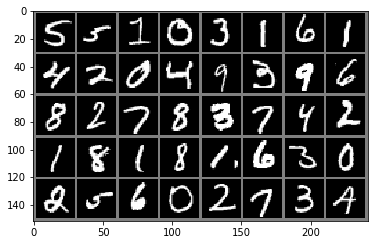

In [445]:
noiseset = dset.mnist.MNIST(root = 'data/mnist', download=True, transform=transform)
noiseloader = torch.utils.data.DataLoader(noiseset, batch_size=BATCH_SIZE * 10, shuffle=True)

# get some random training images
dataiter = iter(noiseloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

## Train model

In [420]:
# define model
model = Model(n_units)

# define classifier
k = 10
classifier = lambda X: 1 - sigmoid(torch.Tensor([k]).log() - model(X, log=True).squeeze())

optimizer = torch.optim.Adam(model.parameters(), lr=.1)  # i had to change this learning rate to get this to train

# train
train_model(classifier, optimizer, trainloader, noiseloader, n_batches=100)

Batch: 0 | Loss: 0.304
Batch: 10 | Loss: 0.027
Batch: 20 | Loss: 0.0111
Batch: 30 | Loss: 0.00611
Batch: 40 | Loss: 0.00505
Batch: 50 | Loss: 0.00318
Batch: 60 | Loss: 0.00284
Batch: 70 | Loss: 0.0029
Batch: 80 | Loss: 0.0023
Batch: 90 | Loss: 0.00217


## Sampling

Once more, the (ideal) goal of this model is to fit a function $p(x)$ to some data, such that we can:

1. Evaluate its likelihood (wherein it actually tells us that data to which the model was fit is more likely than data to which it was not)
2. Draw realistic samples

From a Boltzmann machine, our primary strategy for drawing samples is via Gibbs sampling. It's slow, and I do not believe it's meant to work particularly well. Let's draw 5 samples and see how we do.

In [422]:
%%time

samples = model.sample(n_samples=30, burn_in=25, every_n=1)

CPU times: user 4min 10s, sys: 4.09 s, total: 4min 14s
Wall time: 4min 17s


Takes forever!

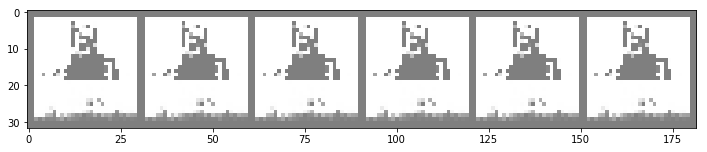

In [447]:
plt.figure(figsize=(12, 12))
imshow(torchvision.utils.make_grid(torch.stack(samples).view(len(samples), 1, 28, 28)))

Nothing great. These samples are highly correlated, if perfectly identical, as expected. 

To generate better images, we'll have to let this run for a lot longer and "thin" the chain (taking every `every_n` samples, where `every_n` is on the order of 1, 10, or 100, roughly).

## Summary

In this post, we discussed four additional strategies for both speeding up, as well as outright avoiding, the computation of the gradient of the log-partition function $\nabla_{\theta}\log{Z}$.

While we only presented toy models here, these strategies see successful application in larger undirected graphical models, as well as directed conditional models for $p(y\vert x)$. One key example of the latter is a language model; though the partition function is a sum over distinct values of $y$ (labels) instead of configurations of $x$ (inputs), it can still be intractable to compute! This is because there are as many distinct values of $y$ as there are tokens in the given language's vocabulary, which is typically on the order of millions.

Thanks for reading.